# CytoData 2023 Hackathon

This is an example Notebook that presents how the hackathon data can be used.

In [1]:
# Import used libraries
import re
import random
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics
import umap
import umap.plot
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

In [2]:
imgpath = Path('images')
trainfeat_path = Path('metadata/cytodata2023_hackathon_features_train.csv')
testfeat_path = Path('metadata/cytodata2023_hackathon_features_test.csv')
trainmeta_path = Path('metadata/cytodata2023_hackathon_train.csv')
testmeta_path = Path('metadata/cytodata2023_hackathon_test.csv')
channels = ['1_AF488', '1_AF555', '1_AF647', '1_AF750', '1_DAPI', '2_AF647']

## Helper functions

In [3]:
def crop_rgb_tiles(img, cshape, rand_boxes=0):
    boxes = []
    if rand_boxes > 0:
        for i in range(rand_boxes):
            boxes.append((np.random.randint(0,img.shape[0]-cshape[0]), np.random.randint(0,img.shape[1]-cshape[1])))
    else:
        boxes = [(y,x) for x in range((img.shape[1]%cshape[1])//2, img.shape[1]-cshape[1], cshape[1])
                 for y in range((img.shape[0]%cshape[0])//2, img.shape[0]-cshape[0], cshape[0])]
    
    tiles = np.zeros((len(boxes),cshape[0],cshape[1],3), dtype=np.float32)
    for i,(sx,sy) in enumerate(boxes):
        cimg = img[sy:sy+cshape[0], sx:sx+cshape[1]]
        tiles[i,:,:,0] = cimg
        tiles[i,:,:,1] = cimg
        tiles[i,:,:,2] = cimg
    
    return tiles

## Read and check metadata and features

In [4]:
df_metadata_train = pd.read_csv(trainmeta_path)
df_features_train = pd.read_csv(trainfeat_path)

In [5]:
# Add Test information in the df_features
df_features_train = df_features_train.merge(df_metadata_train, on=['Slide','ROI number'], how='left')

In [6]:
# Check metadata
df_metadata_train

,Slide,ROI number,PatientID,Location,Annotation Color,Progression,pT,Fuhrman
0,TMA-06,29,1,3,Blue2,1,3,2
1,TMA-09,66,2,2,Red1,1,2,3
2,TMA-07,67,4,3,Blue1,1,3,3
3,TMA-03,52,8,3,Blue2,0,3,2
4,TMA-06,27,1,2,Red2,1,3,2
...,...,...,...,...,...,...,...,...
237,TMA-04,127,68,2,Red1,0,1,1
238,TMA-01,11,58,2,Red1,0,1,2
239,TMA-03,124,34,3,Blue2,0,1,2
240,TMA-07,107,23,3,Blue1,1,1,2


In [7]:
# Check features
df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Annotation Color,Progression,pT,Fuhrman
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.014145,0.004990,0.013458,0.005539,58,2,Red1,0,1,2
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.009567,0.004273,0.008797,0.003876,58,2,Red1,0,1,2
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.013588,0.005570,0.011788,0.004410,58,2,Red1,0,1,2
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.013287,0.004776,0.099508,0.013188,58,2,Red1,0,1,2
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.053239,0.006271,0.032040,0.010449,58,2,Red1,0,1,2
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.007000,0.003857,0.005947,0.003220,58,2,Red1,0,1,2
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.011872,0.004395,0.008614,0.004223,58,2,Red1,0,1,2
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.011040,0.003418,0.007980,0.003799,58,2,Red1,0,1,2
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.015732,0.006256,0.016266,0.006222,58,2,Red1,0,1,2
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.010986,0.005005,0.011402,0.004410,58,2,Red1,0,1,2


## Visualize images

Open a random core and visualize it.

In [8]:
idx = df_metadata_train.sample(n=1).index[0]
imgpaths = imgpath.glob(df_metadata_train.loc[idx,'Slide']+'*roi{:03d}*'.format(df_metadata_train.loc[idx,'ROI number']))
imgpaths = [x for x in imgpaths]
imgpaths.sort()

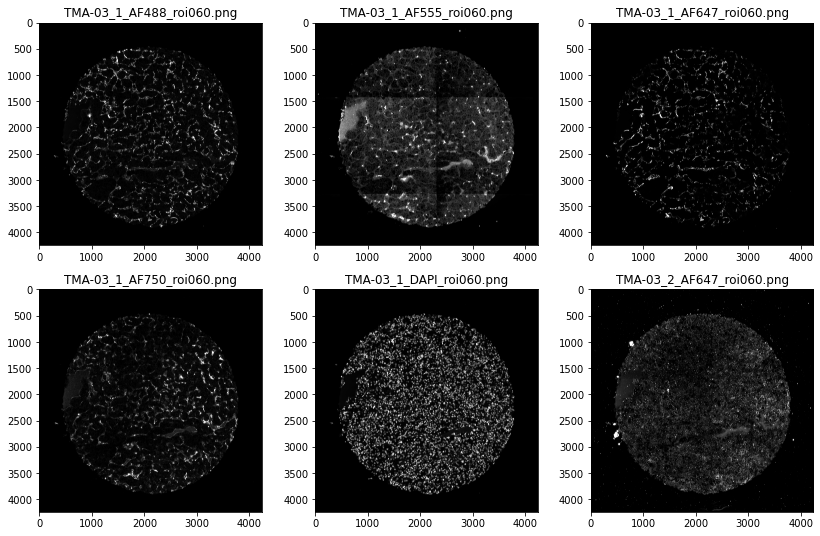

In [9]:
# There should be 6 images to view
rows = 2
cols = 3
fig,ax = plt.subplots(rows,cols,figsize=(14,9))
for i,ipath in enumerate(imgpaths):
    img = imageio.imread(ipath).astype(np.float32)
    # Scale images from median (bg) to 0.998 quantile for visualization
    intlow,inthigh = np.quantile(img,[0.5,0.998])
    img = (img - intlow) / (inthigh-intlow)
    img[img<0.0] = 0.0
    img[img>1.0] = 1.0
    img = (img * 255.0).astype(np.uint8)
    ax[i//cols, i%cols].imshow(img, cmap='gray')
    ax[i//cols, i%cols].set_title(ipath.name)

## Classical features

### Preprocess features

In [10]:
# Feature columns
featcols = [x for x in df_features_train.columns if 'Intensity' in x]

In [11]:
# drop NA
prep_features = df_features_train.dropna()

In [12]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(prep_features[featcols])
prep_features.loc[:,featcols] = scaler.transform(prep_features[featcols])
prep_features = prep_features.dropna()

In [13]:
# Visualize 10% of the single-cell features of training data
mapper = umap.UMAP()
umap_sample = prep_features[featcols].sample(frac=0.1)
mapper.fit(umap_sample)

/home/user/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<AxesSubplot:>

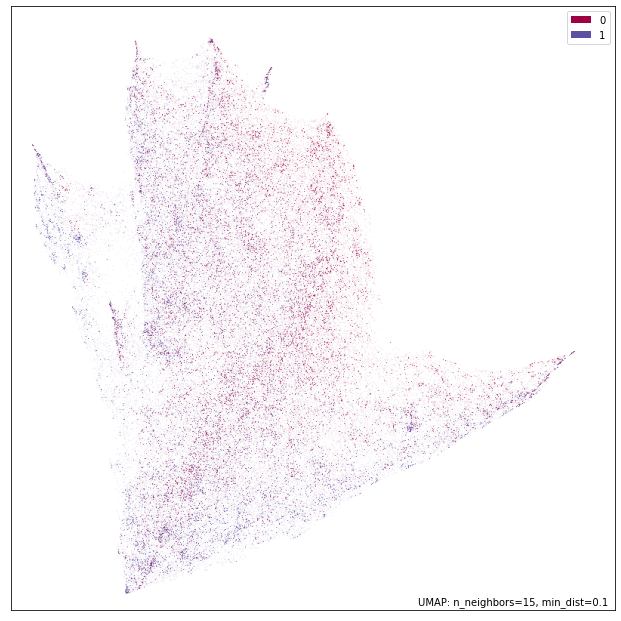

In [14]:
umap.plot.points(mapper, labels=prep_features.loc[umap_sample.index,'Progression'])

In [15]:
# Median features for each ROI
med_features = prep_features.groupby(['Slide','ROI number']).median().reset_index()

### Toy classification example

In [16]:
# Use single-cell features for classification
# Sample 30% to validation
X_train = med_features[featcols].sample(frac=0.7)
y_train = med_features.loc[X_train.index,'Progression']
X_test = med_features.loc[~med_features.index.isin(X_train.index),featcols]
y_test = med_features.loc[X_test.index,'Progression']

In [17]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [19]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.863
Precision: 0.917
Recall: 0.825


## DL features with pretrained network

In [20]:
input_shape = (256,256,3)
dl_featcols = ['feat_{}'.format(x) for x in range(2048)]

In [21]:
# Check channel distributions for preprocessing using 20% of images (NOTE: mixes train and test images)
ch_dist = {}
for ch in channels:
    files = [x for x in imgpath.glob(f'*{ch}*')]
    files = random.choices(files, k=int(len(files)*0.2))
    dist = np.zeros((len(files),2), dtype=np.float32)
    for i,fpath in tqdm(enumerate(files)):
        img = imageio.imread(fpath)
        dist[i,0] = img.mean()
        dist[i,1] = img.std()
    ch_dist[ch] = (np.mean(dist[:,0]), np.mean(dist[:,1]))

76it [01:13,  1.04it/s]
76it [01:01,  1.23it/s]
76it [00:59,  1.28it/s]
76it [01:10,  1.07it/s]
76it [01:16,  1.01s/it]
76it [01:17,  1.02s/it]


In [22]:
ch_dist

{'1_AF488': (604.866, 1171.5526),
 '1_AF555': (173.54794, 227.04192),
 '1_AF647': (602.9319, 1669.038),
 '1_AF750': (347.22284, 459.65744),
 '1_DAPI': (1426.2677, 1958.8918),
 '2_AF647': (1366.6309, 2961.386)}

In [23]:
# Load pretrained model
resnet = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')
resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 128, 128, 64) 256         conv1[0][0]                      
_____________________________________

In [24]:
# Extract features separately for each image, sample 64 boxes per image
num_boxes = 64
df_dlrois = []
for idx,row in tqdm(df_metadata_train.iterrows()):
    ipaths = imgpath.glob(row['Slide']+'*roi{:03d}*'.format(row['ROI number']))
    pat = re.compile('{}_(\d_\w+)_roi{:03d}.png'.format(row['Slide'],row['ROI number']))
    df_dlchs = []
    for ipath in ipaths:
        ch = pat.match(ipath.name).group(1)
        img = imageio.imread(ipath).astype(np.float32)
        img = (img - ch_dist[ch][0]) / ch_dist[ch][1]
        tiles = crop_rgb_tiles(img, input_shape, rand_boxes=num_boxes)
        feat = np.zeros((tiles.shape[0],2048), dtype=np.float32)
        feat = resnet.predict(tiles)
        df_dlroi = pd.DataFrame(columns=[ch+'_'+x for x in dl_featcols], data=feat)
        df_dlchs.append(df_dlroi)
    df_dlch = pd.concat(df_dlchs, axis=1)
    df_dlch['Slide'] = row['Slide']
    df_dlch['ROI number'] = row['ROI number']
    df_dlrois.append(df_dlch)
df_dlfeat = pd.concat(df_dlrois)

242it [27:41,  6.87s/it]


### Preprocess and visualize

In [25]:
dl_featcols = [x for x in df_dlfeat.columns if 'feat' in x]
df_dlfeat

,1_AF750_feat_0,1_AF750_feat_1,1_AF750_feat_2,1_AF750_feat_3,1_AF750_feat_4,1_AF750_feat_5,1_AF750_feat_6,1_AF750_feat_7,1_AF750_feat_8,1_AF750_feat_9,...,1_AF647_feat_2040,1_AF647_feat_2041,1_AF647_feat_2042,1_AF647_feat_2043,1_AF647_feat_2044,1_AF647_feat_2045,1_AF647_feat_2046,1_AF647_feat_2047,Slide,ROI number
0,-1.482776,1.261295,1.176167,-1.388434,5.970962,-2.211917,-1.308791,1.934105,-0.564838,-1.423593,...,-1.291697,-1.268072,1.075451,-1.632883,-1.325238,5.016831,-0.903670,-1.913540,TMA-06,29
1,-1.559009,-0.744786,-0.160020,-1.450327,6.693364,-3.151429,-0.675227,4.708538,0.281269,-1.714302,...,-1.377820,-1.255948,1.083827,-1.600430,-1.327307,5.008068,-0.900630,-1.927919,TMA-06,29
2,1.229875,0.182554,-0.160526,-1.496801,4.854014,-0.505489,0.852368,3.353003,0.099592,-1.917983,...,-1.292838,-1.264898,1.073422,-1.627616,-1.324961,5.016275,-0.900976,-1.911963,TMA-06,29
3,-0.871595,0.521979,0.991889,-0.851867,4.943773,-2.950845,-0.154666,-0.830263,-1.006202,-1.568388,...,-1.288935,-1.269493,1.074793,-1.631275,-1.327098,5.015766,-0.901855,-1.911543,TMA-06,29
4,2.634571,0.069512,1.238442,-1.208019,3.994922,-1.669249,-0.757657,-0.264993,-0.426516,-0.832206,...,-1.282647,-1.268457,1.072016,-1.633967,-1.323660,5.012323,-0.896200,-1.911528,TMA-06,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.335633,1.308005,1.168626,-1.731363,5.101438,-0.146266,0.349213,-1.039749,-0.936006,-1.253774,...,-1.289803,-1.270594,1.077795,-1.629607,-1.327258,5.002263,-0.898920,-1.912445,TMA-08,52
60,-1.403136,-0.425766,1.722669,-0.324357,4.671619,-2.394099,-0.780125,3.593484,0.295909,-1.372713,...,-1.299163,-1.270414,1.087354,-1.624890,-1.329297,5.011557,-0.862120,-1.914955,TMA-08,52
61,-1.402001,-0.164293,1.902804,-0.848373,6.172301,-3.273144,0.233333,2.633988,-0.139604,-1.731292,...,-1.293877,-1.266166,1.077326,-1.620725,-1.324629,5.010055,-0.901758,-1.913048,TMA-08,52
62,-1.529747,-0.836315,-0.142127,-1.474288,6.998038,-3.120993,-0.624998,5.395930,0.144274,-1.948921,...,-1.295360,-1.270023,1.076082,-1.628538,-1.326704,5.017133,-0.895262,-1.913642,TMA-08,52


In [26]:
dlfeat = df_dlfeat.copy()
dlfeat = dlfeat.merge(df_metadata_train, on=['Slide','ROI number'], how='left')
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(dlfeat[dl_featcols])
dlfeat.loc[:,dl_featcols] = scaler.transform(dlfeat[dl_featcols])
dlfeat = dlfeat.dropna()

In [27]:
train_feat = dlfeat.sample(frac=0.7)
test_feat = dlfeat.loc[~dlfeat.index.isin(train_feat.index),:]

In [28]:
# Visualize single-cell features of the training data
umap_sample = train_feat.sample(frac=0.1)
mapper = umap.UMAP()
mapper.fit(umap_sample[dl_featcols])

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<AxesSubplot:>

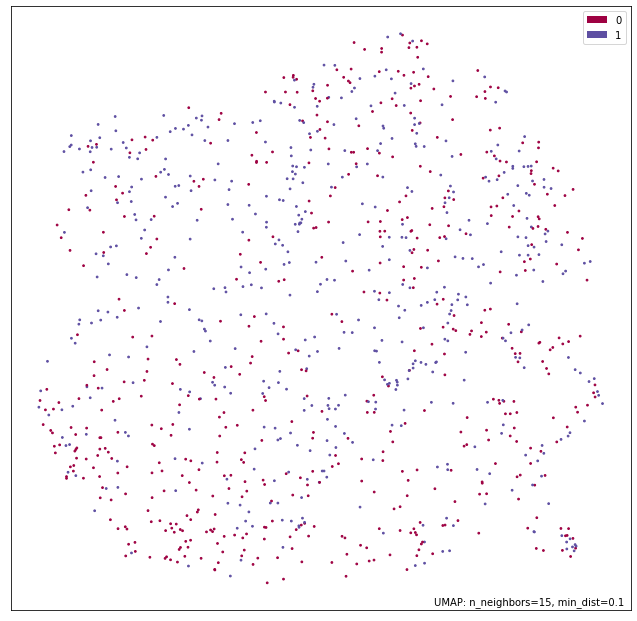

In [29]:
umap.plot.points(mapper, labels=umap_sample['Progression'])

### Toy classification with DL features

In [30]:
med_train_feat = train_feat.groupby(["Slide","ROI number"]).median().reset_index()
med_test_feat = test_feat.groupby(["Slide","ROI number"]).median().reset_index()

In [31]:
# Use single-cell features for classification
X_train = med_train_feat[dl_featcols]
y_train = med_train_feat['Progression']
X_test = med_test_feat[dl_featcols]
y_test = med_test_feat['Progression']

In [32]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [34]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.864
Precision: 0.885
Recall: 0.833
